# Computational Statistics - Problem 17
It is not always possible to perform a cross validation as in problem 16 (e.g.
due to run time or lack of a sufficient number of observations or a reliable
ground truth). An alternative is the usage of model based selection criteria.
The most popular selection criteria are the Akaike information criterion ($AIC$)
and the Bayesian information criterion ($BIC$). The $AIC$ is given by $AIC =
n \cdot log(RSS/n)-n \cdot log(n)+2 \cdot log(df)$, where $RSS = \sum_{i=1}^{n}(y_i - \hat{y_i})^2$ are the residual
sum of squares, $n$ is the number of observations and $df$ is the number of degrees
of freedom required for the estimate. The $ BIC = n \cdot log(RSS/n) - n \cdot log(n) +
n \cdot log(df) $ is defined very similar and favors less complex models. We use the
same EHEC data as in problem 16 to now derive the best model for prediction
based on the $AIC$ and $BIC$.

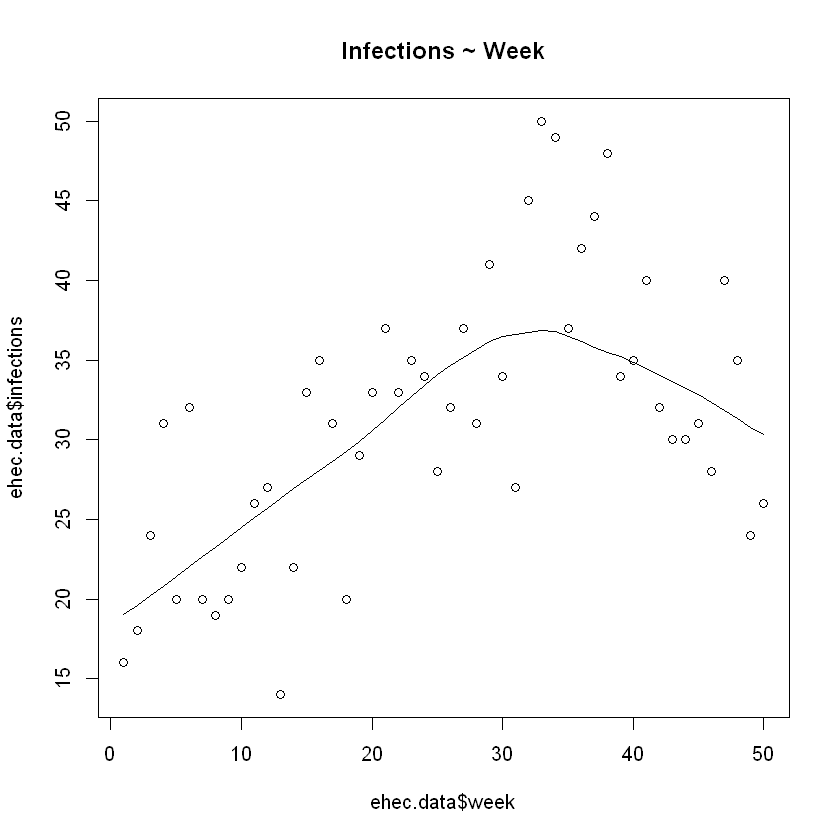

In [1]:
ehec.data <- read.table('./ehec.csv', sep = ';', header = FALSE, col.names=c('week', 'infections'))
scatter.smooth(x=ehec.data$week, y=ehec.data$infections, main="Infections ~ Week")

## A

The degrees of freedom of a regression estimator is the number of parameters
to be estimated. Equivalently, for an estimator of the type $\hat{Y} = SY$
it is also the trace of the hat matrix $S$, $ tr(S) = \sum_{i=1}^n S_{ii}$. Determine the
degrees of freedom for the linear regression model of 16 A using these
two approaches.

In [2]:
lin.reg <- lm(infections ~ week, ehec.data)
lin.reg$coefficients

writeLines("Linear regression has 2 parameters -> df = 2")

writeLines(sprintf("df: %s", sum(lm.influence(lin.reg)$hat)))

X <- ehec.data$week
H <- X %*% solve(t(X) %*% X) %*% t(X)
writeLines(sprintf("df calculated with trace 'by hand': %s", sum(diag(H))))
writeLines("-> difference due to intercept")

(Intercept)        week 
 23.1322449   0.3171669

Linear regression has 2 parameters -> df = 2
df: 2
df calculated with trace 'by hand': 1
-> difference due to intercept


## B

For the Nadaraya-Watson estimator, we can only rely on estimating the
trace of the hat matrix. The hat matrix of the Nadaraya-Watson estimator
can be computed using the following R-function. Compute the
degrees of freedom for a Nadaraya-Watson estimator with a Gaussian
kernel and bandwidths $h_2 = 2$, $h_3 = 5$, and $h_4 = 10$.

In [3]:
#funtion provided in exercise sheet
getHatMatrix <- function(x,h){
    #initialiaze a 0 matrix
    Snw <- matrix(0, nrow = length(x), ncol = length(x))
    #get a matrix of the standard basis vectors
    In <- diag(length(x)) ## identity matrix
    #add influence of each standard basis vector
    for(j in 1:length(x)){
        y <- In[,j]
        Snw[,j] <- ksmooth(x,y,bandwidth=h,x.points=x)$y
    }
    return(Snw)
}

getDf <- function(x,h) {
    hat = getHatMatrix(x, h)
    return(sum(diag(hat)))
}

hs <- c(1, 2, 5, 10)
for(h in hs) {
    writeLines(sprintf('h = %s: df = %s', h, getDf(ehec.data$week, h)))
}

h = 1: df = 50
h = 2: df = 17
h = 5: df = 10.3666666666667
h = 10: df = 4.92763347763348


## C
Compute the residual sum of squares ($RSS$) for all bandwidths considered
and for the linear regression model.

In [4]:
rss <- function(y, y.hat) {
    return(sum((y - y.hat)^2))
}

rss.lin.reg <- sum((lin.reg$residuals)^2)
writeLines(sprintf("linear regression\nrss = %s\n", rss.lin.reg))

writeLines("\nkernel")
for(h in hs) {
    y.hat <- ksmooth(ehec.data$week, ehec.data$infection, bandwidth=h, x.points=ehec.data$week)$y
    writeLines(sprintf('h = %s: rss = %s', h, rss(ehec.data$infections, y.hat)))
}

linear regression
rss = 2563.13642256903


kernel
h = 1: rss = 0
h = 2: rss = 722.666666666667
h = 5: rss = 1295.46055555556
h = 10: rss = 1416.6471516859


## D
Compute the $AIC$ for all models. Which model has the smallest $AIC$
and should thus be prefered?

In [5]:
aic <- function(n, rss, df) {
    return(n * log(rss/n) - n * log(n) + 2 * log(df))
}

aic2 <- function(n, rss, df) {
    return(n * log(rss/n) - n * log(n) + 2 * df)
}

writeLines("linear regression")
writeLines(sprintf("aic (exercise) = %s", aic(50, rss.lin.reg, 2)))
writeLines(sprintf("aic (slides) = %s", aic2(50, rss.lin.reg, 2)))
writeLines(sprintf("aic (built-in 1) = %s", AIC(lin.reg)))
writeLines(sprintf("aic (built-in 2) = %s", extractAIC(lin.reg)[2]))

writeLines("\n\nkernel")
for(h in hs) {
    kernel <- ksmooth(ehec.data$week, ehec.data$infections, bandwidth=h, x.points=ehec.data$week)
    y.hat <- kernel$y
    kernel.rss <- rss(ehec.data$infections, y.hat)
    kernel.aic <- aic(50, kernel.rss, getDf(ehec.data$week, h))
    kernel.aic2 <- aic2(50, kernel.rss, getDf(ehec.data$week, h))
    
    writeLines(sprintf('h = %s: aic (exercise) = %s', h, kernel.aic))
    writeLines(sprintf('h = %s: aic (slides) = %s', h, kernel.aic2))
}

linear regression
aic (exercise) = 2.63334145017305
aic (slides) = 5.24704708905315
aic (built-in 1) = 344.742050680928
aic (built-in 2) = 200.84819736046


kernel
h = 1: aic (exercise) = -Inf
h = 1: aic (slides) = -Inf
h = 2: aic (exercise) = -56.3884701601308
h = 2: aic (slides) = -28.0548968482432
h = 5: aic (exercise) = -28.1940318685863
h = 5: aic (slides) = -12.1378895962872
h = 10: aic (exercise) = -25.2101729530982
h = 10: aic (slides) = -18.5446236938012


## E
Compute the $BIC$ for all models. Which model has the smallest $BIC$
and should thus be prefered?

In [6]:
bic <- function(n, rss, df) {
    return(n * log(rss/n) - n * log(n) + n * log(df))
}

bic2 <- function(n, rss, df) {
    return(n * log(rss/n) - n * log(n) + df * log(n))
}

writeLines("linear regression")
writeLines(sprintf("bic (exercise) = %s", bic(length(lin.reg$residuals), rss.lin.reg, 2)))
writeLines(sprintf("bic (slides) = %s", bic2(length(lin.reg$residuals), rss.lin.reg, 2)))
writeLines(sprintf("bic (built-in) = %s", BIC(lin.reg)))

writeLines("\n\nkernel")
for(h in hs) {
    kernel <- ksmooth(ehec.data$week, ehec.data$infections, bandwidth=h, x.points=ehec.data$week)
    y.hat <- kernel$y
    kernel.rss <- rss(ehec.data$infections, y.hat)
    kernel.bic <- bic(50, kernel.rss, getDf(ehec.data$week, h))
    kernel.bic2 <- bic2(50, kernel.rss, getDf(ehec.data$week, h))
    
    writeLines(sprintf('h = %s: bic (exercise) = %s', h, kernel.bic))
    writeLines(sprintf('h = %s: bic (slides) = %s', h, kernel.bic2))
}

linear regression
bic (exercise) = 35.9044061170504
bic (slides) = 9.07109309990945
bic (built-in) = 350.478119697212


kernel
h = 1: bic (exercise) = -Inf
h = 1: bic (slides) = -Inf
h = 2: bic (exercise) = 79.6057703545676
h = 2: bic (slides) = 4.44949424403525
h = 5: bic (exercise) = 84.0585535962335
h = 5: bic (slides) = 7.68341555998462
h = 10: bic (exercise) = 51.3430517501821
h = 10: bic (slides) = -9.1228751222481
